In [130]:
# Import pytorch et Coco dataset
import torch
from torchvision import datasets
from torch import nn, optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
# import cv2
import matplotlib.pyplot as plt
# import skimage
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms
from pathlib import Path
import skimage 
import cv2

Pour la prochaine fois tester avec les nouveaux paramètres de normalisation pour les cannaux a et b

In [131]:
img_path = Path('val2017/')
files = sorted(img_path.iterdir())


In [134]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.ToTensor()
])
# real_valid_set = CustomDataset(test_dataset, lab_mode=False)

In [160]:
image = files[0]
for image_path in files:
    img_rgb = Image.open(image_path)
    if np.array(transform(img_rgb)).shape !=(128,128,3):
        files.remove(image_path)

In [323]:
best_max = -130
best_min = 130
for image_path in files:
    img_rgb = np.array(Image.open(image_path))
    image_lab = skimage.color.rgb2lab(img_rgb)
    potential_max = np.max(image_lab[:,:,1:])
    potential_min = np.min(image_lab[:,:,1:])
    if best_max < potential_max :
        best_max = potential_max
    if best_min > potential_min :
        best_min = potential_min

In [254]:
print(len(files))
img_rgb = np.array(transform((Image.open(files[0]))))
image_lab = skimage.color.rgb2lab(img_rgb/255)
print(image_lab.shape)
print(np.max(image_lab[:,:,1:]))

4990
(128, 128, 3)
56.127749149958106


In [324]:
print(best_max)
print(best_min)

97.84112959410635
-107.78406784845407


In [325]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.target_transform = target_transform
        print("len : ", len(self.image_paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_rgb = Image.open(self.image_paths[idx])
        # numpy_image_rgb = np.array(rgb_image)
        img_rgb = np.array(self.transform((img_rgb)))
        # print(img_rgb.shape)
        # image_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        image_lab = skimage.color.rgb2lab(img_rgb)
        image_input = image_lab[:, :,0]
        image_input = np.reshape(image_input, [1, 128, 128])
        image_output = image_lab[:,:, 1:]
        image_output = np.swapaxes(np.swapaxes(image_output, 0, 2), 1, 2)
        # image_output = np.reshape(image_output, [1, 2, 128, 128])
        return torch.from_numpy(image_input/100), torch.from_numpy((image_output + 108)/206) # paramètres à revoir
        

In [166]:
img_rgb = Image.open(files[0])
image_lab = np.array(skimage.color.rgb2lab(transform((img_rgb))))
image_input = image_lab[:, :,0]
image_output = image_lab[:, :,1:]
print(image_output.shape)

(128, 128, 2)


In [326]:
real_training_set = CustomDataset(image_paths = files, transform=transform)

len :  4990


In [327]:
data_loader_lab = DataLoader(real_training_set, batch_size=20, shuffle=True)

In [100]:

index_image = 8
color, cmap = False, "gray"
plt.imshow(real_training_set.toDisplay(index_image, color=color), cmap=cmap)
plt.subplots_adjust(left=0.4, right=0.5, top=0.5, bottom=0.4)
plt.axis('off')
plt.show()

AttributeError: 'CustomDataset' object has no attribute 'toDisplay'

In [328]:
class NeuralNetwork(nn.Module):
    def __init__(self, lab_mode=True):
        super().__init__()
        self.criterion = nn.MSELoss()
        if lab_mode == True :
          nb_final_channel = 2
        else :
          nb_final_channel = 3
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(in_channels=128, out_channels= 256, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3,3)),
            nn.UpsamplingNearest2d(size =(16,16)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels= 64, kernel_size=(3,3)),
            nn.UpsamplingNearest2d(size =(32,32)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels= 32, kernel_size=(3,3)),
            nn.UpsamplingNearest2d(size =(64,64)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=nb_final_channel, kernel_size=(3,3)),
            nn.UpsamplingNearest2d(size =(128,128)),
            nn.Sigmoid()
        )
        self.optimizer = optim.Adam(self.parameters())

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

    def fit(self, data_loader, num_epochs=10):
      for epoch in range(num_epochs):
        self.train() # Surtout nécessaire si on fait du dropout ou de la batch normalisation
        epoch_loss = 0.0
        print("ui")
        for inputs, targets in data_loader:
            #inputs = np.reshape(inputs, [20,1,128,128])
            outputs = self.forward(inputs.float())
            #print(outputs.shape)
            #print(targets.shape)
            loss = self.criterion(outputs, targets.float())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
        print(f"Époque {epoch + 1}/{num_epochs}, Perte moyenne: {epoch_loss / len(data_loader):.4f}")

In [329]:
model = NeuralNetwork()
model.fit(data_loader_lab)

ui
Époque 1/10, Perte moyenne: 0.0050
ui
Époque 2/10, Perte moyenne: 0.0048
ui
Époque 3/10, Perte moyenne: 0.0047
ui
Époque 4/10, Perte moyenne: 0.0046
ui
Époque 5/10, Perte moyenne: 0.0046
ui
Époque 6/10, Perte moyenne: 0.0046
ui
Époque 7/10, Perte moyenne: 0.0045
ui
Époque 8/10, Perte moyenne: 0.0045
ui
Époque 9/10, Perte moyenne: 0.0045
ui
Époque 10/10, Perte moyenne: 0.0044


In [336]:
for inputs, targets in data_loader_lab:
    outputs = model.forward(inputs.float()).detach().numpy()
    target = targets.detach().numpy()
    break
inputs = inputs.detach().numpy()
print(np.max(outputs))
print(np.min(target))
max_L = 2.55
min_L =0 
print(outputs.shape)
print(target.shape)

0.6247917
0.1632491401076337
(20, 2, 128, 128)
(20, 2, 128, 128)


In [337]:
print(inputs.shape)
image_recomposed = np.concatenate((inputs, outputs), axis = 1)
print(image_recomposed.shape)
image_recomposed = image_recomposed.astype(np.float32)
original_images = np.concatenate((inputs, target), axis = 1).astype(np.float32)
# rgb_image = cv2.cvtColor(image_recomposed, cv2.COLOR_Lab2RGB)

(20, 1, 128, 128)
(20, 3, 128, 128)


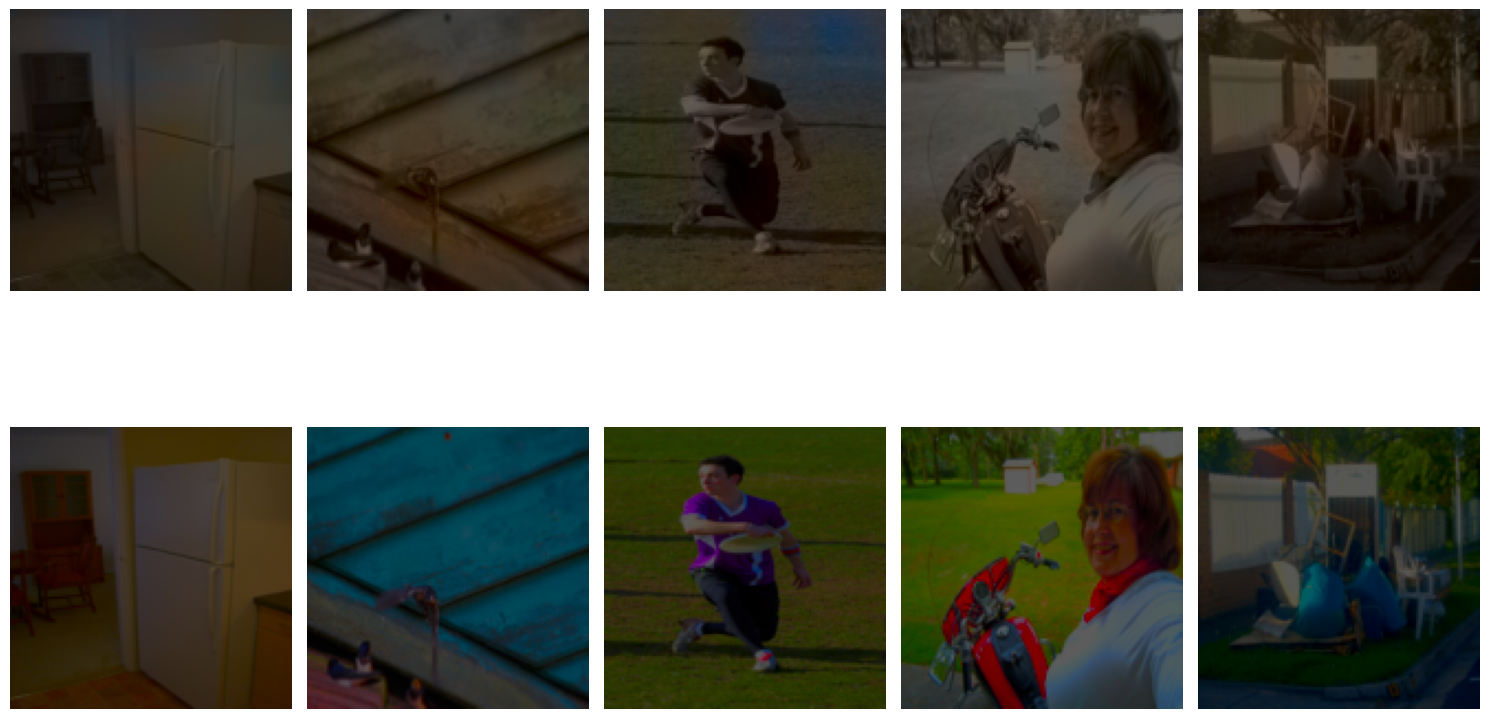

In [338]:
num_images = 5
fig, axes = fig, axes = plt.subplots(2, num_images, figsize=(15, 10))

for i in range(num_images):
    original_lab_image = original_images[i]
    original_lab_image[0] = ((original_lab_image[0] - min_L) / (max_L -min_L))*100
    original_lab_image[1:] = original_lab_image[1:] *206  - 108
    lab_image = image_recomposed[i]
    lab_image[0] = ((lab_image[0] - min_L) / (max_L -min_L))*100
    lab_image[1:] = lab_image[1:] *206.1  - 107
        
    rgb_image = skimage.color.lab2rgb(lab_image.transpose(1, 2, 0)) 
    rgb_image_target = skimage.color.lab2rgb(original_lab_image.transpose(1, 2, 0)) 


    ax = axes[0, i]  # Première ligne
    ax.imshow(rgb_image)
    ax.axis('off')

    ax = axes[1, i]  # Deuxième ligne
    ax.imshow(rgb_image_target)
    ax.axis('off')

plt.tight_layout()  # Ajuste l'espacement entre les sous-graphes pour éviter les chevauchements
plt.show()
